Import libraries and data

In [56]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import pandas as pd
from IPython.display import display, Image

In [57]:
pickle_file = 'SVHN.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
    
  train_image_labels = train_labels.index
  test_image_labels = test_labels.index
    
train_labels = train_labels.values
test_labels = test_labels.values

Convert six labels (including # of images) into five labels (with an extra label meaning, no number in this position)

In [58]:
def six_labels_to_five(test_labels):    
    test_labels_sample_orig = pd.DataFrame(test_labels).copy()
    num_lab_orig = pd.DataFrame(test_labels).ix[:,50:54].copy()
    num_lab_new = num_lab_orig.copy()
    num_lab_new[num_lab_new==0] = np.nan
    num_lab_new = num_lab_new.T
    num_lab_new = num_lab_new.fillna(method='bfill')
    num_lab_new = num_lab_new.T
    num_lab_new[num_lab_new==1] = 0
    num_lab_new = num_lab_new.fillna(1)
    test_labels_sample_orig.ix[:,50:54] = num_lab_new
    cols = test_labels_sample_orig.columns.tolist()
    cols = cols[:10] + cols[50:51] + cols[10:20] + cols[51:52] + cols[20:30] + cols[52:53] + cols[30:40] + cols[53:54] + cols[40:50] + cols[54:55]
    test_labels_sample_orig = test_labels_sample_orig.fillna(0)
    test_labels_sample_new = test_labels_sample_orig[cols]
    return test_labels_sample_new

test_labels = six_labels_to_five(test_labels)
train_labels = six_labels_to_five(train_labels)

Test a couple of images to make sure everything lines up

[[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]
8006


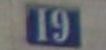

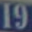

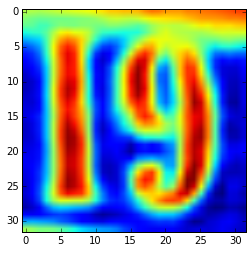

In [63]:
%matplotlib inline
index_to_test = 8000
plt.imshow(train_dataset[index_to_test])
print(train_labels.values[index_to_test].reshape(5,11))
print(train_image_labels[index_to_test])
train_label_filename_cropped = "train/cropped/" + str(train_image_labels[index_to_test]) + ".png"
train_label_filename = "train/" + str(train_image_labels[index_to_test]) + ".png"
display(Image(filename=train_label_filename))
display(Image(filename=train_label_filename_cropped))

[[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]
8007


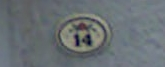

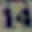

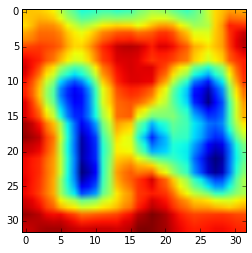

In [64]:
%matplotlib inline
plt.imshow(test_dataset[index_to_test])
print(test_labels.values[index_to_test].reshape(5,11))
print(test_image_labels[index_to_test])
test_label_filename_cropped = "test/cropped/" + str(test_image_labels[index_to_test]) + ".png"
test_label_filename = "test/" + str(test_image_labels[index_to_test]) + ".png"
display(Image(filename=test_label_filename))
display(Image(filename=test_label_filename_cropped))

In [65]:
train_image_labels_spec = ["train/cropped/" + str(i) + ".png" for i in train_image_labels]
test_image_labels_spec = ["test/cropped/" + str(i) + ".png" for i in test_image_labels]

merged_dataset = np.concatenate((train_dataset,test_dataset))
merged_labels = np.concatenate((train_labels,test_labels))
merged_image_labels = np.concatenate((train_image_labels_spec,test_image_labels_spec))

def randomize(dataset, labels, image_labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  shuffled_image_labels = image_labels[permutation]
  return shuffled_dataset, shuffled_labels, shuffled_image_labels
merged_dataset, merged_labels, merged_image_labels = randomize(merged_dataset, merged_labels, merged_image_labels)

[[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]
train/cropped/13638.png


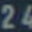

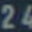

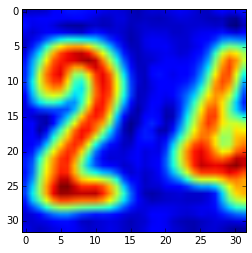

In [66]:
plt.imshow(merged_dataset[index_to_test])
print(merged_labels[index_to_test].reshape(5,11))
print(merged_image_labels[index_to_test])
merged_label_filename_cropped = str(merged_image_labels[index_to_test])
merged_label_filename = str(merged_image_labels[index_to_test])
display(Image(filename=merged_label_filename))
display(Image(filename=merged_label_filename_cropped))

In [67]:
train_dataset = merged_dataset[0:merged_dataset.shape[0]/2,]
valid_dataset = merged_dataset[(merged_dataset.shape[0]/2):
                                    (merged_dataset.shape[0]/2+merged_dataset.shape[0]/4),]
test_dataset = merged_dataset[(merged_dataset.shape[0]/2+merged_dataset.shape[0]/4):merged_dataset.shape[0],]

train_labels = merged_labels[0:merged_labels.shape[0]/2,]
valid_labels = merged_labels[(merged_labels.shape[0]/2):
                                    (merged_labels.shape[0]/2+merged_labels.shape[0]/4),]
test_labels = merged_labels[(merged_labels.shape[0]/2+merged_labels.shape[0]/4):merged_labels.shape[0],]

train_image_labels = merged_image_labels[0:merged_image_labels.shape[0]/2,]
valid_image_labels = merged_image_labels[(merged_image_labels.shape[0]/2):
                                    (merged_image_labels.shape[0]/2+merged_image_labels.shape[0]/4),]
test_image_labels = merged_image_labels[(merged_image_labels.shape[0]/2+merged_image_labels.shape[0]/4):merged_image_labels.shape[0],]


In [68]:
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (23216, 32, 32) (23216, 55)
Validation set (11608, 32, 32) (11608, 55)
Test set (11609, 32, 32) (11609, 55)


[[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]
test/cropped/2222.png


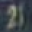

<IPython.core.display.Image object>

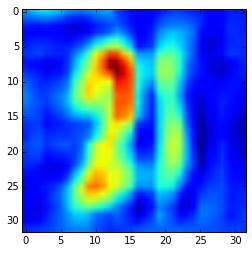

In [69]:
index_to_test = 21000

print(train_labels[index_to_test].reshape(5,11))
print(train_image_labels[index_to_test])
train_label_filename_cropped = str(train_image_labels[index_to_test])
train_label_filename = str(train_image_labels[index_to_test])
display(Image(filename=train_label_filename))
#display(Image(filename=train_label_filename_cropped))
display(Image(plt.imshow(train_dataset[index_to_test])))

In [70]:
train_labels_1 = train_labels[:,0:11]
train_labels_2 = train_labels[:,11:22]
train_labels_3 = train_labels[:,22:33]
train_labels_4 = train_labels[:,33:44]
train_labels_5 = train_labels[:,44:55]
#train_labels_6 = train_labels[:,50:55]

valid_labels_1 = valid_labels[:,0:11]
valid_labels_2 = valid_labels[:,11:22]
valid_labels_3 = valid_labels[:,22:33]
valid_labels_4 = valid_labels[:,33:44]
valid_labels_5 = valid_labels[:,44:55]
#valid_labels_6 = valid_labels[:,50:55]

test_labels_1 = test_labels[:,0:11]
test_labels_2 = test_labels[:,11:22]
test_labels_3 = test_labels[:,22:33]
test_labels_4 = test_labels[:,33:44]
test_labels_5 = test_labels[:,44:55]
#test_labels_6 = test_labels[:,50:55]

In [71]:
def accuracy(predictions, labels):
  labels_1 = labels[:,0:11]
  labels_2 = labels[:,11:22]
  labels_3 = labels[:,22:33]
  labels_4 = labels[:,33:44]
  labels_5 = labels[:,44:55]

  predictions_1 = predictions[:,0:11]
  predictions_2 = predictions[:,11:22]
  predictions_3 = predictions[:,22:33]
  predictions_4 = predictions[:,33:44]
  predictions_5 = predictions[:,44:55]
    
  total_observations = predictions.shape[0]
  #print(predictions[:,:11])
  acc_1 = np.argmax(predictions_1, 1) == np.argmax(labels_1, 1)
  acc_2 = np.argmax(predictions_2, 1) == np.argmax(labels_2, 1)
  acc_3 = np.argmax(predictions_3, 1) == np.argmax(labels_3, 1)
  acc_4 = np.argmax(predictions_4, 1) == np.argmax(labels_4, 1)
  acc_5 = np.argmax(predictions_5, 1) == np.argmax(labels_5, 1)

  acc = acc_1 & acc_2 & acc_3 & acc_4 & acc_5
  
  #print(predictions_1[0])
  #print(labels_1[0])
  #print("Predicted: " + str(np.argmax(predictions_1[0])) + " " + str(np.argmax(predictions_2[0]))  + " " + 
  #      str(np.argmax(predictions_3[0]))  + " " + str(np.argmax(predictions_4[0]))  + " " + str(np.argmax(predictions_5[0])))
  #print("Actual: " + str(np.argmax(labels_1[0])) + " " + str(np.argmax(labels_2[0]))  + " " + 
  #      str(np.argmax(labels_3[0]))  + " " + str(np.argmax(labels_4[0]))  + " " + str(np.argmax(labels_5[0])))

  return (100.0 * np.sum(acc)
          / predictions.shape[0])

In [76]:
image_size = 32
num_labels = 11
num_channels = 1 # grayscale

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = labels.astype(np.int32)
  return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (23216, 32, 32, 1) (23216, 55)
Validation set (11608, 32, 32, 1) (11608, 55)
Test set (11609, 32, 32, 1) (11609, 55)


In [80]:
batch_size = 100
patch_size = 5
depth = 16
num_hidden = 64
image_size = 32
num_channels = 1
num_labels = 11
num_numbers = 5

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))

    tf_train_labels1 = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_train_labels2 = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_train_labels3 = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_train_labels4 = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_train_labels5 = tf.placeholder(tf.float32, shape=(batch_size, num_labels))

    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset) 

    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))
    layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth, depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    layer3_weights = tf.Variable(tf.truncated_normal([image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))

    number1_weights = tf.get_variable("WS1", shape=[num_hidden, num_labels],\
        initializer=tf.contrib.layers.xavier_initializer())
    number1_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    number2_weights = tf.get_variable("WS2", shape=[num_hidden, num_labels],\
        initializer=tf.contrib.layers.xavier_initializer())
    number2_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    number3_weights = tf.get_variable("WS3", shape=[num_hidden, num_labels],\
        initializer=tf.contrib.layers.xavier_initializer())
    number3_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    number4_weights = tf.get_variable("WS4", shape=[num_hidden, num_labels],\
        initializer=tf.contrib.layers.xavier_initializer())
    number4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    number5_weights = tf.get_variable("WS5", shape=[num_hidden, num_labels],\
        initializer=tf.contrib.layers.xavier_initializer())
    number5_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))

    # Model.
    def model(data):
        #first convolutional layer
        conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)
        #second convolutional layer
        conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        #fully-connected layer
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        #layers for the 5 numbers and length
        logits1 = tf.matmul(hidden, number1_weights) + number1_biases
        logits2 = tf.matmul(hidden, number2_weights) + number2_biases
        logits3 = tf.matmul(hidden, number3_weights) + number3_biases
        logits4 = tf.matmul(hidden, number4_weights) + number4_biases
        logits5 = tf.matmul(hidden, number5_weights) + number5_biases
        return logits1, logits2, logits3, logits4, logits5

    # Training computation.
    #print(logits1.shape)
    #logits1, logits2, logits3, logits4, logits5, logits6 = model(tf_train_dataset)
    logits1, logits2, logits3, logits4, logits5 = model(tf_train_dataset)
    #print(logits1) 
    #print(tf_train_labels1)
    #print(logits6)
    
    #print(logits1)
    #print(logits2)
    #print(logits3)
    #print(logits4)
    #print(logits5)

    loss1 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits1, tf_train_labels1))
    loss2 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits2, tf_train_labels2))
    loss3 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits3, tf_train_labels3))
    loss4 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits4, tf_train_labels4))
    loss5 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits5, tf_train_labels5))

    loss = loss1 + loss2 + loss3 + loss4 + loss5
    #loss = loss1

    #loss = tf.add_n(loss_per_digit)

    '''
    loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits1, tf_train_labels1) + 
    tf.nn.softmax_cross_entropy_with_logits(logits2, tf_train_labels2) + 
    tf.nn.softmax_cross_entropy_with_logits(logits3, tf_train_labels3) + 
    tf.nn.softmax_cross_entropy_with_logits(logits4, tf_train_labels5) + 
    tf.nn.softmax_cross_entropy_with_logits(logits5, tf_train_labels5) + 
    tf.nn.softmax_cross_entropy_with_logits(logits6, tf_train_labels6))
    '''

    # Optimizer.
    # learning rate decay
    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, 100, 0.96, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

    #optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.concat(1, [tf.nn.softmax(logits1), tf.nn.softmax(logits2), tf.nn.softmax(logits3),
                          tf.nn.softmax(logits4), tf.nn.softmax(logits5)])
    #train_prediction_6 = tf.nn.softmax(logits6)

    valid_logits1, valid_logits2, valid_logits3, valid_logits4, valid_logits5 = model(tf_valid_dataset)
    test_logits1, test_logits2, test_logits3, test_logits4, test_logits5 = model(tf_test_dataset)

    valid_prediction = tf.concat(1, [tf.nn.softmax(valid_logits1), tf.nn.softmax(valid_logits2), 
                                              tf.nn.softmax(valid_logits3),
                          tf.nn.softmax(valid_logits4), tf.nn.softmax(valid_logits5)])

    test_prediction = tf.concat(1, [tf.nn.softmax(test_logits1), tf.nn.softmax(test_logits2), tf.nn.softmax(test_logits3),
                          tf.nn.softmax(test_logits4), tf.nn.softmax(test_logits5)])

In [81]:
#batch_size = 100
#num_steps = 10000
num_steps = 100000

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]

    batch_labels = train_labels[offset:(offset + batch_size), :]
    batch_labels1 = train_labels_1[offset:(offset + batch_size), :]
    batch_labels2 = train_labels_2[offset:(offset + batch_size), :]
    batch_labels3 = train_labels_3[offset:(offset + batch_size), :]
    batch_labels4 = train_labels_4[offset:(offset + batch_size), :]
    batch_labels5 = train_labels_5[offset:(offset + batch_size), :]
    
    batch_image_labels = train_image_labels[offset:(offset + batch_size)]

    feed_dict = {tf_train_dataset : batch_data, tf_train_labels1 : batch_labels1, tf_train_labels2 : batch_labels2
                , tf_train_labels3 : batch_labels3, tf_train_labels4 : batch_labels4, tf_train_labels5 : batch_labels5}
    
    # 
    _, l, l1, l2, l3, l4, l5, predictions = session.run([optimizer, loss, loss1, loss2, loss3, loss4, loss5, train_prediction], feed_dict=feed_dict)
       
       
    if (step % 500 == 0):
        %matplotlib inline
        index_to_test = 0
        
        #print(logits1)
        print(np.around(predictions[index_to_test],2).reshape(5,11))
        
        '''
        print("Validating image")
        plt.imshow(batch_data[index_to_test])
        plt.show()
        print(batch_labels[index_to_test].reshape(5,11))
        print(batch_image_labels[index_to_test])
        batch_label_filename_cropped = str(batch_image_labels[index_to_test])
        batch_label_filename = str(batch_image_labels[index_to_test])
        display(Image(filename=batch_label_filename))
        #display(Image(filename=batch_label_filename_cropped))
        print("End Validating image")
        '''
        
        #print(batch_labels[0].reshape(5,11))
        print('Minibatch loss at step %d: %f' % (step, l))
        print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
        print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
[[ 0.          0.80000001  0.          0.          0.          0.
   0.18000001  0.          0.          0.          0.01      ]
 [ 0.          0.          0.          0.02        0.          0.04        0.08
   0.02        0.47999999  0.01        0.37      ]
 [ 0.          0.          0.          0.          0.69999999  0.25        0.
   0.          0.          0.04        0.        ]
 [ 0.14        0.01        0.11        0.02        0.          0.52999997
   0.01        0.17        0.02        0.          0.        ]
 [ 0.13        0.          0.43000001  0.11        0.          0.          0.
   0.          0.13        0.15000001  0.04      ]]
Minibatch loss at step 0: 33.721176
Minibatch accuracy: 0.0%
Validation accuracy: 0.9%
[[ 0.          0.25999999  0.18000001  0.15000001  0.11        0.08        0.08
   0.05        0.05        0.04        0.        ]
 [ 0.11        0.1         0.08        0.09        0.09        0.08        0.09
   0.07        0.06        0.06   

KeyboardInterrupt: 